Research Project Code to compare the CNN architectures on a binary classification project to compare the performances of different architectures.

In [21]:
!pip install -q torchinfo timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.1 MB/s eta 0:00:00


In [27]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import datasets,models
from torchvision.transforms import v2 as transforms
from torchvision.ops import Conv2dNormActivation
from timm import create_model

from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import seaborn as sn

import matplotlib.pyplot as plt
import time
import numpy as np
import random
import warnings
import os
from tqdm import tqdm

import pandas as pd

%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
#Set seed for reproducibilty
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
       torch.cuda.manual_seed(seed)
       torch.cuda.manual_seed_all(seed)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = True

set_seed(42)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip /content/drive/MyDrive/Dataset.zip -d/content

Archive:  /content/drive/MyDrive/Dataset.zip
   creating: /content/Dataset/
   creating: /content/Dataset/NotTotalLoss/
  inflating: /content/Dataset/NotTotalLoss/0002.JPEG  
  inflating: /content/Dataset/NotTotalLoss/0005.JPEG  
  inflating: /content/Dataset/NotTotalLoss/0007.JPEG  
  inflating: /content/Dataset/NotTotalLoss/0010.JPEG  
  inflating: /content/Dataset/NotTotalLoss/0011.JPEG  
  inflating: /content/Dataset/NotTotalLoss/0014.JPEG  
  inflating: /content/Dataset/NotTotalLoss/0016.JPEG  
  inflating: /content/Dataset/NotTotalLoss/0017.JPEG  
  inflating: /content/Dataset/NotTotalLoss/0019.JPEG  
  inflating: /content/Dataset/NotTotalLoss/0025.jpeg  
  inflating: /content/Dataset/NotTotalLoss/0026.JPEG  
  inflating: /content/Dataset/NotTotalLoss/0033.JPEG  
  inflating: /content/Dataset/NotTotalLoss/0034.JPEG  
  inflating: /content/Dataset/NotTotalLoss/0039.JPEG  
  inflating: /content/Dataset/NotTotalLoss/0042.JPEG  
  inflating: /content/Dataset/NotTotalLoss/0044.JPEG  


In [7]:
transform_224 = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a common size for CNN input
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])  # Normalize (ImageNet stats)
])

In [9]:
dataset_path = '/content/Dataset'
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform_224)
full_dataset_299 = datasets.ImageFolder(root=dataset_path, transform=transform_299)

total_size = len(full_dataset)
print(f"Total dataset size: {total_size}")

total_size = len(full_dataset)
train_size = int(0.8 * total_size)

train_size = int(0.8 * total_size)
test_size = total_size - train_size

if train_size + test_size != total_size:
    raise ValueError(f"Split lengths ({train_size} + {test_size}) do not equal dataset length ({total_size})")

torch.manual_seed(42)
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Check class names
class_names = full_dataset.classes
print("Class names:", class_names)


Total dataset size: 275
Class names: ['NotTotalLoss', 'TotalLoss']


In [10]:
for img_path, label in full_dataset.imgs:
    if 'TotalLoss' in img_path:
        print(f"Image: {img_path}, Label: {label}")

for img_path, label in full_dataset.imgs:
    if 'NotTotalLoss' in img_path:
        print(f"Image: {img_path}, Label: {label}")

Image: /content/Dataset/NotTotalLoss/0002.JPEG, Label: 0
Image: /content/Dataset/NotTotalLoss/0005.JPEG, Label: 0
Image: /content/Dataset/NotTotalLoss/0007.JPEG, Label: 0
Image: /content/Dataset/NotTotalLoss/0010.JPEG, Label: 0
Image: /content/Dataset/NotTotalLoss/0011.JPEG, Label: 0
Image: /content/Dataset/NotTotalLoss/0014.JPEG, Label: 0
Image: /content/Dataset/NotTotalLoss/0016.JPEG, Label: 0
Image: /content/Dataset/NotTotalLoss/0017.JPEG, Label: 0
Image: /content/Dataset/NotTotalLoss/0019.JPEG, Label: 0
Image: /content/Dataset/NotTotalLoss/0025.jpeg, Label: 0
Image: /content/Dataset/NotTotalLoss/0026.JPEG, Label: 0
Image: /content/Dataset/NotTotalLoss/0033.JPEG, Label: 0
Image: /content/Dataset/NotTotalLoss/0034.JPEG, Label: 0
Image: /content/Dataset/NotTotalLoss/0039.JPEG, Label: 0
Image: /content/Dataset/NotTotalLoss/0042.JPEG, Label: 0
Image: /content/Dataset/NotTotalLoss/0044.JPEG, Label: 0
Image: /content/Dataset/NotTotalLoss/0048.JPEG, Label: 0
Image: /content/Dataset/NotTota

In [47]:
def create_model(model_name, num_classes=2, freeze_backbone=True):
    if model_name == 'alexnet':
        model = models.alexnet(pretrained=True)
        num_features = model.classifier[6].in_features
        model.classifier[6] = torch.nn.Linear(num_features, num_classes)
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        num_features = model.classifier[6].in_features
        model.classifier[6] = torch.nn.Linear(num_features, num_classes)
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        num_features = model.fc.in_features
        model.fc = torch.nn.Linear(num_features, num_classes)
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        num_features = model.classifier.in_features
        model.classifier = torch.nn.Linear(num_features, num_classes)
    elif model_name == 'convnext_tiny':
        model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT) # num_classes=0 to remove default head
        num_features = model.classifier[2].in_features  # For ConvNeXt, the classifier is a Sequential with Linear at index 2
        model.classifier[2] = torch.nn.Linear(num_features, num_classes)
    else:
        raise ValueError("Unsupported model name")

    # Assign the global train_loader and test_loader (no need for local variables here)
    global train_loader, test_loader

    # Freeze or unfreeze backbone (optional)
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze the final layers (e.g., classifier or fc)
        if model_name in ['alexnet', 'vgg16']:
            for param in model.classifier.parameters():
                param.requires_grad = True
        elif model_name in ['resnet50', 'densenet121']:
            for param in model.fc.parameters() if model_name == 'resnet50' else model.classifier.parameters():
                param.requires_grad = True
        elif model_name == 'convnext_tiny':
            for param in model.classifier.parameters():
                param.requires_grad = True
    else:
        for param in model.parameters():
            param.requires_grad = True

    return model, train_loader, test_loader

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
def train_model(model, model_name, train_loader, num_epochs=10):
    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

    train_losses, train_accuracies = [], []
    best_train_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            if model_name == 'inception_v3':
                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]  # Use main output
            else:
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        if train_acc > best_train_acc:
            best_train_acc = train_acc
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
            print(f"Saved best model for {model_name} with accuracy: {train_acc:.4f}")

        print(f'{model_name} - Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

    return {
        'model': model_name,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies
    }

In [49]:
def evaluate_model(model, model_name, test_loader):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()

    test_loss = 0.0
    correct = 0
    total = 0
    test_preds, test_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if model_name == 'inception_v3':
                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]  # Use main output
            else:
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = correct / total

    test_precision, test_recall, _, _ = precision_recall_fscore_support(test_labels, test_preds, average='binary')

    print(f'{model_name} - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, '
          f'Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}')

    return {
        'model': model_name,
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'test_precision': test_precision,
        'test_recall': test_recall
    }

In [52]:
def plot_training_curves(results):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    for result in results:
        if 'train_losses' in result and 'test_loss' in result:
            plt.plot(result['train_losses'], label=f'{result["model"]} Train Loss')
            plt.axhline(y=result['test_loss'], color=plt.gca().lines[-1].get_color(), linestyle='--', label=f'{result["model"]} Test Loss')
    plt.title('Training and Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    for result in results:
        if 'train_accuracies' in result and 'test_accuracy' in result:
            plt.plot(result['train_accuracies'], label=f'{result["model"]} Train Accuracy')
            plt.axhline(y=result['test_accuracy'], color=plt.gca().lines[-1].get_color(), linestyle='--', label=f'{result["model"]} Test Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Training alexnet...
Saved best model for alexnet with accuracy: 0.6227
alexnet - Epoch [1/10], Train Loss: 1.4226, Train Acc: 0.6227
Saved best model for alexnet with accuracy: 0.7091
alexnet - Epoch [2/10], Train Loss: 0.6552, Train Acc: 0.7091
Saved best model for alexnet with accuracy: 0.8909
alexnet - Epoch [3/10], Train Loss: 0.2648, Train Acc: 0.8909
alexnet - Epoch [4/10], Train Loss: 0.3635, Train Acc: 0.8364
Saved best model for alexnet with accuracy: 0.9455
alexnet - Epoch [5/10], Train Loss: 0.1510, Train Acc: 0.9455
alexnet - Epoch [6/10], Train Loss: 0.2828, Train Acc: 0.9273
alexnet - Epoch [7/10], Train Loss: 0.2235, Train Acc: 0.9455
Saved best model for alexnet with accuracy: 0.9545
alexnet - Epoch [8/10], Train Loss: 0.2173, Train Acc: 0.9545
alexnet - Epoch [9/10], Train Loss: 0.2507, Train Acc: 0.9545
Saved best model for alexnet with accuracy: 0.9727
alexnet - Epoch [10/10], Train Loss: 0.1049, Train Acc: 0.9727
Loading best model from alexnet_best_model.pth
alexn

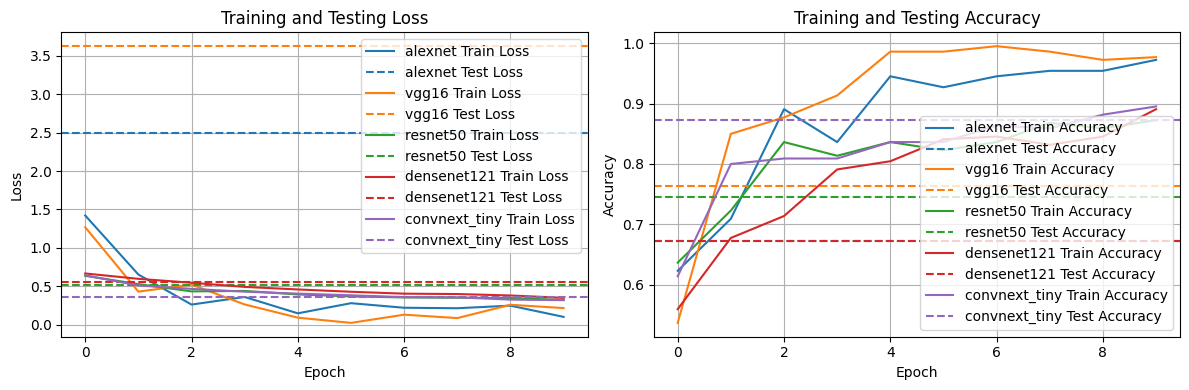

In [53]:
models_to_compare = ['alexnet', 'vgg16', 'resnet50', 'densenet121', 'convnext_tiny']
all_results = []

for model_name in models_to_compare:
    print(f"\nTraining {model_name}...")
    model, train_loader, test_loader = create_model(model_name)  # Unpack three values: model, train_loader, test_loader

    # Train the model
    train_result = train_model(model, model_name, train_loader, num_epochs=10)

    # Check if the best model file exists before loading
    model_path = f'{model_name}_best_model.pth'
    if os.path.exists(model_path):
        print(f"Loading best model from {model_path}")
    else:
        print(f"Best model file {model_path} not found, using current model state")
        torch.save(model.state_dict(), model_path)  # Save the final model as a fallback

    # Evaluate the model
    model.load_state_dict(torch.load(model_path))
    eval_result = evaluate_model(model, model_name, test_loader)

    # Combine results for plotting
    combined_result = {**train_result, **eval_result}
    all_results.append(combined_result)

# Print comparison
print("\nModel Performance Comparison:")
print("-" * 50)
for result in all_results:
    print(f"Model: {result['model']}")
    print(f"Test Accuracy: {result['test_accuracy']:.4f}")
    print(f"Test Precision: {result['test_precision']:.4f}")
    print(f"Test Recall: {result['test_recall']:.4f}")
    print("-" * 50)

# Plot training and testing curves
plot_training_curves(all_results)